In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import pickle
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Unnamed: 0'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [24]:
df.shape

(4608, 2)

In [25]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)

In [26]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X = df.drop(['label'], axis = 1)
Y = df['label']

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42, stratify=Y)
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())


vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()


##### Logistic Regression


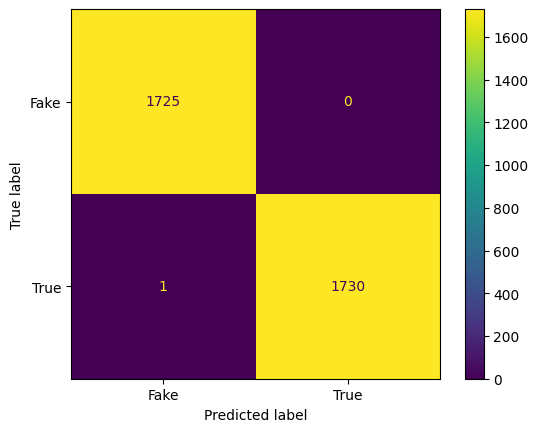

In [28]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)

y_test_pred = lr_classifier.predict(X_train)
y_test_pred = (y_test_pred > 0.75)
cm = confusion_matrix(y_train, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

with open('../models/logisticRegression.pkl', 'wb') as arquivo:
    pickle.dump(lr_classifier, arquivo)


##### Multilayer perceptron (MLP)

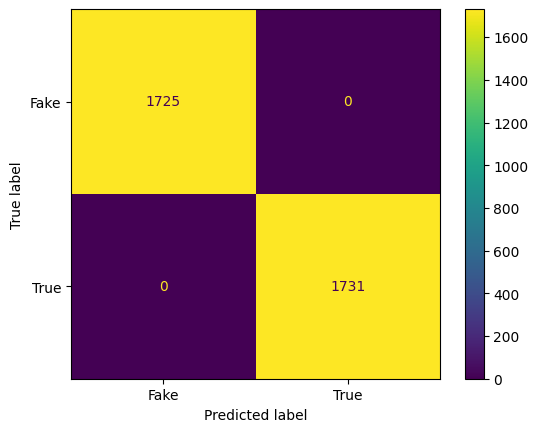

In [29]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train,y_train)

y_test_pred = mlp.predict(X_train)
y_test_pred = (y_test_pred > 0.75)
cm = confusion_matrix(y_train, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

with open('../models/MLPClassifier.pkl', 'wb') as arquivo:
    pickle.dump(mlp, arquivo)

##### Multilayer perceptron (MLP) Com GridSearchCV

c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iter

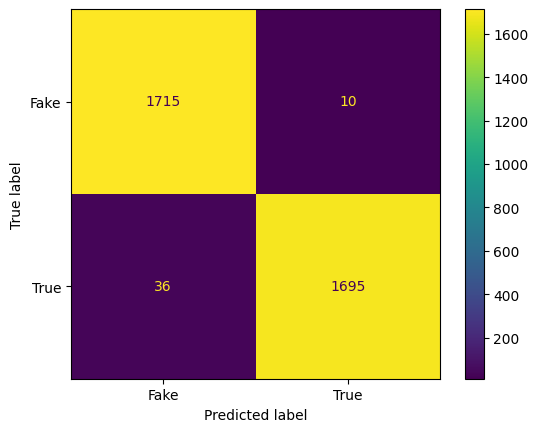

In [30]:
parameters = {'solver': ['sgd', 'lbfgs'],
              'hidden_layer_sizes':(10,5,2), 
              'random_state':[2],
              'activation': ['tanh', 'relu'],
              'max_iter': [50]
              }

clf = GridSearchCV(MLPClassifier(), parameters, cv=2)

clf.fit(X_train,y_train)
y_test_pred = clf.predict(X_train)
y_test_pred = (y_test_pred > 0.75)
cm = confusion_matrix(y_train, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

with open('../models/MLPClassifierWithGridSearchCV.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)

#### Decision Tree

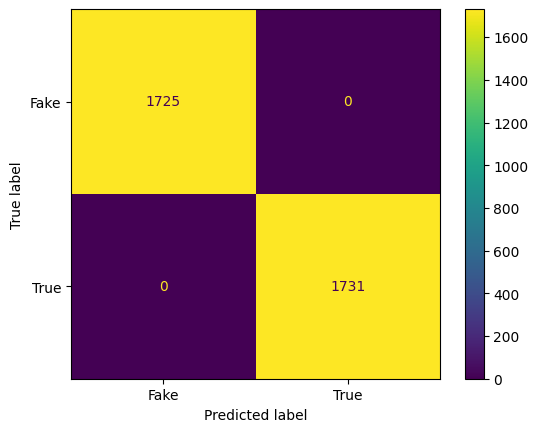

In [31]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train,y_train)
y_test_pred = decisionTree.predict(X_train)
y_test_pred = (y_test_pred > 0.75)
cm = confusion_matrix(y_train, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

with open('../models/DecisionTreeClassifier.pkl', 'wb') as arquivo:
    pickle.dump(decisionTree, arquivo)


#### Passive Aggressive

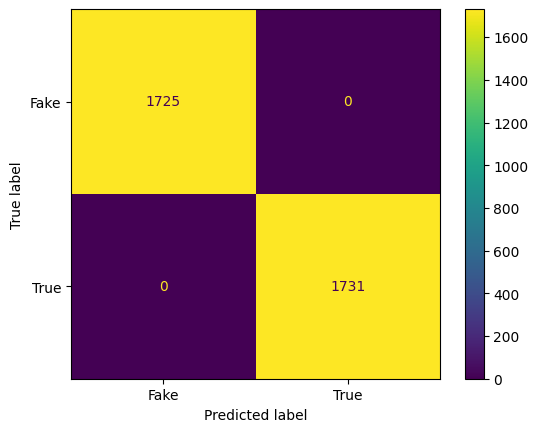

In [32]:
passive = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
passive.fit(X_train,y_train)

x_test_pred = passive.predict(X_test)
y_test_pred = passive.predict(X_train)
y_test_pred = (y_test_pred > 0.75)
cm = confusion_matrix(y_train, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

with open('../models/PassiveAggressiveClassifier.pkl', 'wb') as arquivo:
    pickle.dump(passive, arquivo)

### Comparando Modelos Diferentes

In [ ]:
models = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'PassiveAggressiveClassifier'
    ],
    'Training Accuracy': [
        lr_classifier_train, decisionTree_train,
        mlp_train, passive_train
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, passive_acc
    ]
})

In [ ]:
models.sort_values(by='Model Accuracy Score', ascending=False).style.background_gradient(
        cmap='coolwarm').hide_index().set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })